# NFL 2020 Forecasting Yards Gained

## Data Information

Each row in the file corresponds to a single player's involvement in a single play.

Features:

*Team information*
- Team - home or away
- HomeTeamAbbr - home team abbreviation
- VisitorTeamAbbr - visitor team abbreviation
- HomeScoreBeforePlay - home team score before play started
- VisitorScoreBeforePlay - visitor team score before play started

*Player information*
- DisplayName - player's name
- Position - the player's position (the specific role on the field that they typically play)
- PlayerHeight - player height (ft-in)
- PlayerWeight - player weight (lbs)

*Stadium information*
- StadiumType - description of the stadium environment
- Turf - description of the field surface

*Game information*
- Season - year of the season
- Week - week into the season
- GameWeather - description of the game weather
- Temperature - temperature (deg F)
- Humidity - humidity
- WindSpeed - wind speed in miles/hour
- WindDirection - wind direction

*Play information*
- X - player position along the long axis of the field. See figure below.
- Y - player position along the short axis of the field. See figure below.
- S - speed in yards/second
- A - acceleration in yards/second^2
- Dis - distance traveled from prior time point, in yards
- Orientation - orientation of player (deg)
- Dir - angle of player motion (deg)
- YardLine - the yard line of the line of scrimmage
- Quarter - game quarter (1-5, 5 == overtime)
- GameClock - time on the game clock
- PossessionTeam - team with possession
- Down - the down (1-4)
- Distance - yards needed for a first down
- FieldPosition - which side of the field the play is happening on
- OffenseFormation - offense formation
- OffensePersonnel - offensive team positional grouping
- DefendersInTheBox - number of defenders lined up near the line of scrimmage, spanning the width of the offensive line
- DefensePersonnel - defensive team positional grouping
- PlayDirection - direction the play is headed
- Yards - the yardage gained on the play (you are predicting this)

![features](Images/Features.png "Features")

**Import Packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from string import punctuation
from helper import *
from visualizations import *
%load_ext autoreload
%autoreload 2

## Data Cleaning

**Read Data**

In [2]:
nfl = pd.read_csv('Data/train.csv', dtype={'Season': str})
nfl.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [3]:
nfl.shape

(509762, 49)

In [4]:
nfl.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')

In [3]:
nfl.rename(columns={'X': 'long_axis', 'Y': 'short_axis',
                   'S': 'speed', 'A': 'accel'}, inplace=True)

In [4]:
nfl_id = nfl[['GameId', 'PlayId', 'Team', 'NflId',
              'DisplayName', 'JerseyNumber', 'NflIdRusher',
              'PlayerCollegeName', 'HomeTeamAbbr',
              'VisitorTeamAbbr', 'PlayerBirthDate',
              'Stadium', 'Location']]

nfl = nfl.drop(['GameId', 'PlayId', 'NflId', 'Location',
                'JerseyNumber', 'NflIdRusher',
                'PlayerBirthDate', 'PlayerCollegeName',
                'TimeHandoff', 'TimeSnap', 'Stadium'],
               axis=1)

In [5]:
nfl = replace_null_cols(nfl)

In [6]:
nfl = rename_elements(nfl, nfl_id)

In [7]:
nfl['WindSpeed'] = nfl['WindSpeed'].apply(lambda p: give_me_WindSpeed(p))

In [8]:
nfl['GameClock'] = nfl['GameClock'].apply(strtoseconds)

In [9]:
nfl['WindDirection'] = nfl['WindDirection'].apply(clean_WindDirection)

In [10]:
nfl = organize_team_abbrs(nfl)

In [11]:
nfl['PlayerHeight'] = nfl['PlayerHeight'].apply(lambda x:
                                                12*int(x.split('-')[0])
                                                + int(x.split('-')[1]))

In [12]:
nfl['long_axis'] = nfl.apply(lambda row: row['long_axis']
                             if row['PlayDirection']
                             else 120-row['long_axis'], axis=1)

nfl['Orientation'] = nfl.apply(lambda row:
                               new_orientation(row['Orientation'],
                                               row['PlayDirection']),
                               axis=1)

nfl['Dir'] = nfl.apply(lambda row:
                       new_orientation(row['Dir'],
                                       row['PlayDirection']),
                       axis=1)

In [13]:
nfl['FieldPosition'] = nfl.apply(lambda row: 'Home'
                                 if row['FieldPosition'] == row['TeamAbbr']
                                 else 'Away', axis=1)

In [14]:
nfl['PossessionTeam'] = nfl.apply(lambda row: 'Home'
                                  if row['PossessionTeam'] == row['TeamAbbr']
                                  else 'Away', axis=1)

In [15]:
nfl['Yard_class'] = nfl['Yards'].apply(assign_yard_class)

In [16]:
nfl['GameWeather'] = nfl['GameWeather'].apply(group_weather)

In [19]:
nfl['OffenseFormation'] = nfl['OffenseFormation'].apply(lambda x: 'SINGLEBACK'
                                                        if x == 'ACE'
                                                        else x)

In [21]:
nfl.to_csv('Data/cleaned_nfl.csv', index=False)

## Exploratory Data Analysis (EDA)

In [2]:
nfl = pd.read_csv('Data/cleaned_nfl.csv')
nfl.head()

,Team,long_axis,short_axis,speed,accel,Dis,Orientation,Dir,DisplayName,Season,...,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,TeamAbbr,OppTeamAbbr,Yard_class
0,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,Eric Berry,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
1,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,Allen Bailey,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
2,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,Justin Houston,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
3,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,Derrick Johnson,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
4,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,Ron Parker,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6


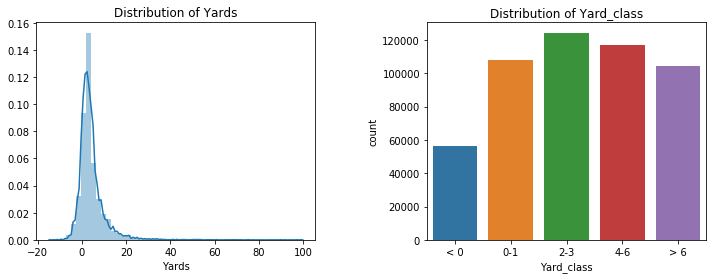

In [26]:
sort_order = ['< 0', '0-1', '2-3', '4-6', '> 6']
two_subplots(nfl, 'Yards', 'Yard_class', num_type=2,
             size=(12, 4), order=sort_order)

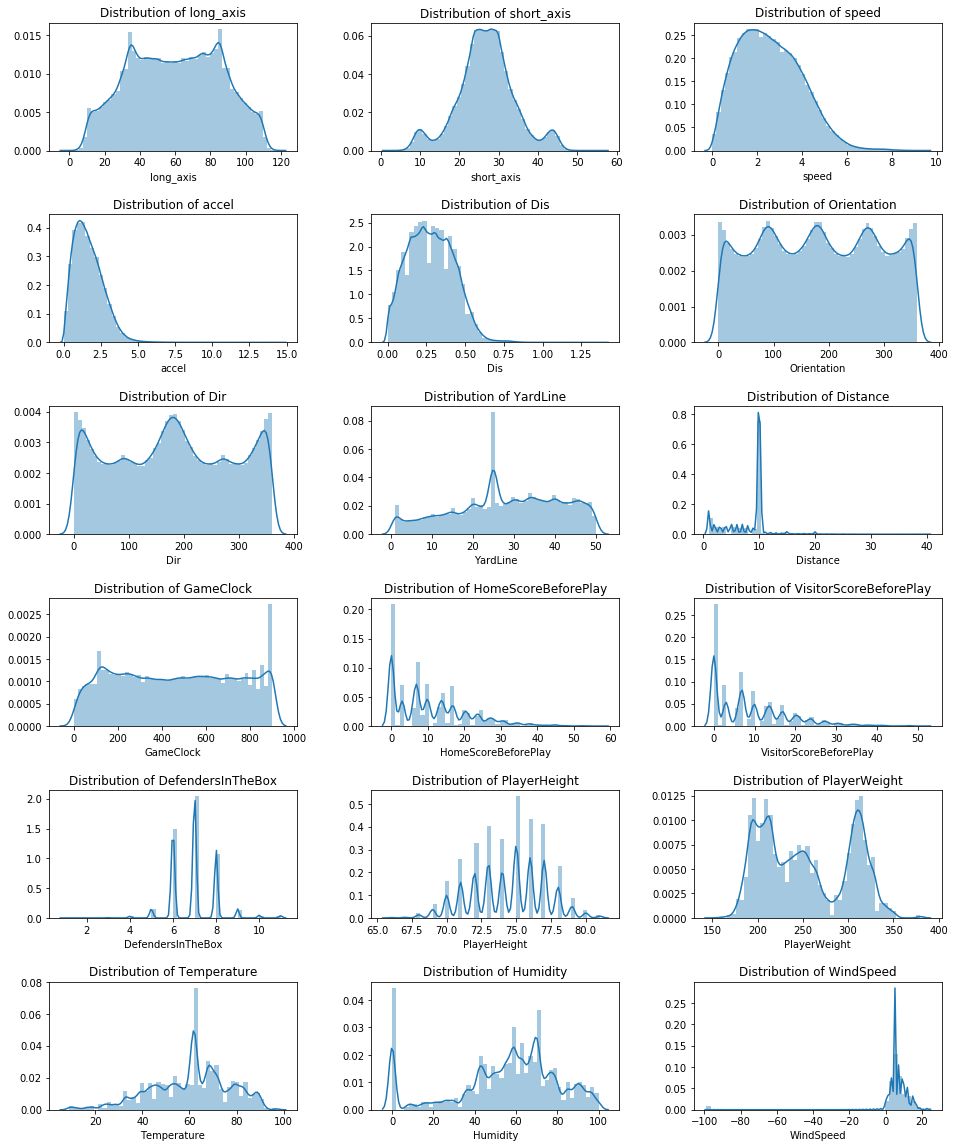

In [22]:
numeric_feats = ['long_axis', 'short_axis', 'speed', 'accel',
                 'Dis', 'Orientation', 'Dir', 'YardLine', 'Distance',
                 'GameClock', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
                 'DefendersInTheBox', 'PlayerHeight', 'PlayerWeight',
                 'Temperature', 'Humidity', 'WindSpeed']

plot_distributions(nfl, numeric_feats)

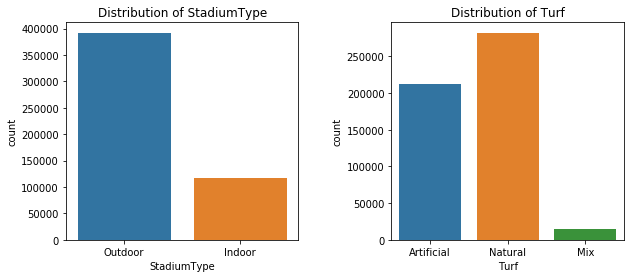

In [29]:
two_subplots(nfl, 'StadiumType', 'Turf', (10, 4));

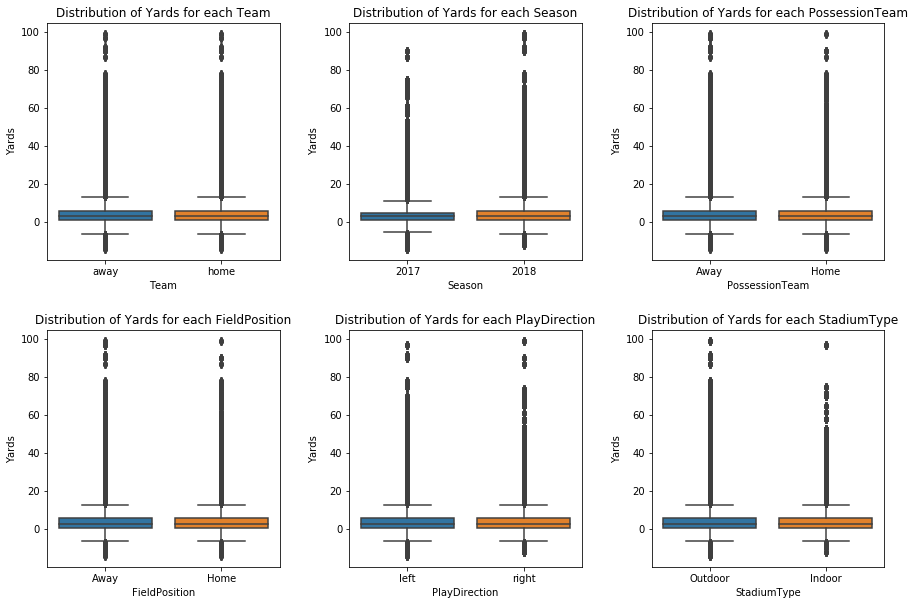

In [25]:
plot_boxplots(nfl, ['Team', 'Season', 'PossessionTeam',
                    'FieldPosition', 'PlayDirection', 'StadiumType'])

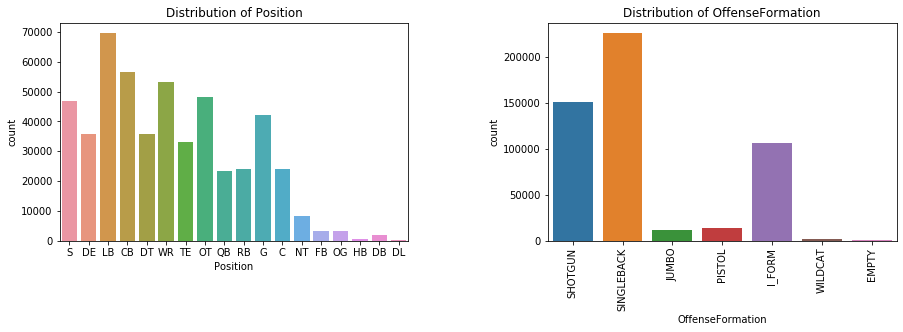

In [24]:
two_subplots(nfl, 'Position', 'OffenseFormation',
             (15, 4), rotate=True)

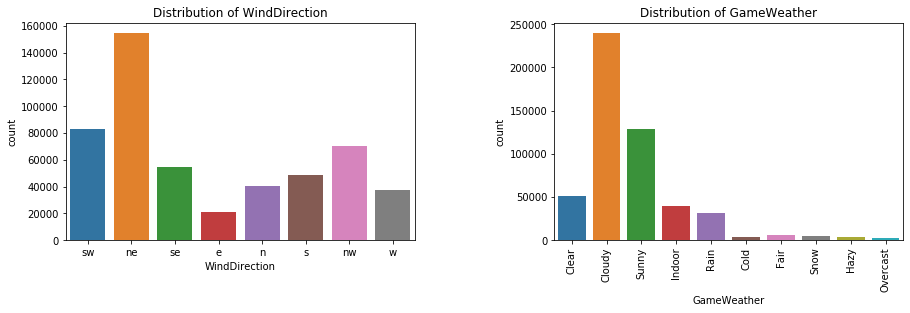

In [26]:
two_subplots(nfl, 'WindDirection', 'GameWeather',
             (15, 4), rotate=True)